# PES Score calculation

##### Author: Jaroslav Crhonek

##### Public domain license - WTFPL https://en.wikipedia.org/wiki/WTFPL

In [1]:
import numpy as np
import pandas as pd
import requests

In [2]:
cz_population = 10699142

## Fetch data from UZIS

In [3]:
persons = pd.DataFrame(requests.get('https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/osoby.json').json().get('data'))
persons['datum'] = pd.to_datetime(persons['datum'])

In [4]:
tests = pd.DataFrame(requests.get('https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/testy.json').json().get('data')).set_index('datum')
tests.index = pd.to_datetime(tests.index)

## Calculate daily counts and combine data

In [5]:
day_count = persons.groupby('datum')['vek'].count().rename('day_count')

In [6]:
senior_day_count = persons.groupby('datum')['vek'].apply(lambda x: x[x >= 65].count()).rename('senior_day_count')

In [7]:
daily_data = pd.concat([day_count, senior_day_count, tests['prirustkovy_pocet_testu'].rename('test_count')], axis=1).sort_index()

## Calculate key metrics for scoring

In [8]:
daily_data['14day_count_per_100k'] = daily_data['day_count'].rolling(14).sum()/cz_population*100000
daily_data['senior_14day_count_per_100k'] = daily_data['senior_day_count'].rolling(14).sum()/cz_population*100000
daily_data['test_positivity'] = (daily_data['day_count']/daily_data['test_count'])*100
daily_data['7day_test_positivity'] = daily_data['test_positivity'].rolling(7).mean()

In [9]:
daily_data['r'] = daily_data['day_count'].rolling(7).sum()/daily_data['day_count'].rolling(7).sum().shift(5)

## Scoring functions

In [10]:
def day_count_score(val):
    if val < 10:
        return 0
    elif val < 25:
        return 2
    elif val < 50:
        return 4
    elif val < 120:
        return 7
    elif val < 240:
        return 10
    elif val < 480:
        return 13
    elif val < 960:
        return 16
    else:
        return 20

In [11]:
def senior_day_count_score(val):
    if val < 10:
        return 0
    elif val < 25:
        return 2
    elif val < 50:
        return 4
    elif val < 120:
        return 7
    elif val < 240:
        return 10
    elif val < 480:
        return 13
    elif val < 960:
        return 16
    else:
        return 20

In [12]:
def r_score(r):
    if r < 0.8:
        return 0
    elif r < 1:
        return 5
    elif r < 1.2:
        return 10
    elif r < 1.4:
        return 15
    elif r < 1.6:
        return 20
    elif r < 1.9:
        return 25
    else:
        return 30

In [13]:
def test_positivity_score(positivity):
    if positivity < 3:
        return 0
    elif positivity < 7:
        return 3
    elif positivity < 11:
        return 7
    elif positivity < 15:
        return 11
    elif positivity < 19:
        return 15
    elif positivity < 23:
        return 20
    elif positivity < 26:
        return 25
    else:
        return 30

## Calculate score

In [14]:
# calculate score
daily_data['14day_count_score'] = daily_data['14day_count_per_100k'].apply(day_count_score)
daily_data['senior_14day_count_score'] = daily_data['senior_14day_count_per_100k'].apply(senior_day_count_score)
daily_data['r_score'] = daily_data['r'].apply(r_score)
daily_data['7day_test_positivity_score'] = daily_data['7day_test_positivity'].apply(test_positivity_score)

# bonus +2 score for weekly increase
daily_data['7day_test_positivity_score'] = np.where(daily_data['7day_test_positivity'] > daily_data['7day_test_positivity'].shift(7), daily_data['7day_test_positivity_score']+2, daily_data['7day_test_positivity_score'])
daily_data['senior_14day_count_score'] = np.where(daily_data['senior_14day_count_per_100k'] > daily_data['senior_14day_count_per_100k'].shift(7), daily_data['senior_14day_count_score']+2, daily_data['senior_14day_count_score'])

# total score
daily_data['score'] = daily_data['14day_count_score'] + \
                        daily_data['senior_14day_count_score'] + \
                        daily_data['r_score'] + \
                        daily_data['7day_test_positivity_score']
daily_data['score'] = np.where(daily_data['score'] > 100, 100, daily_data['score'])

## Visualize score

<AxesSubplot:xlabel='datum'>

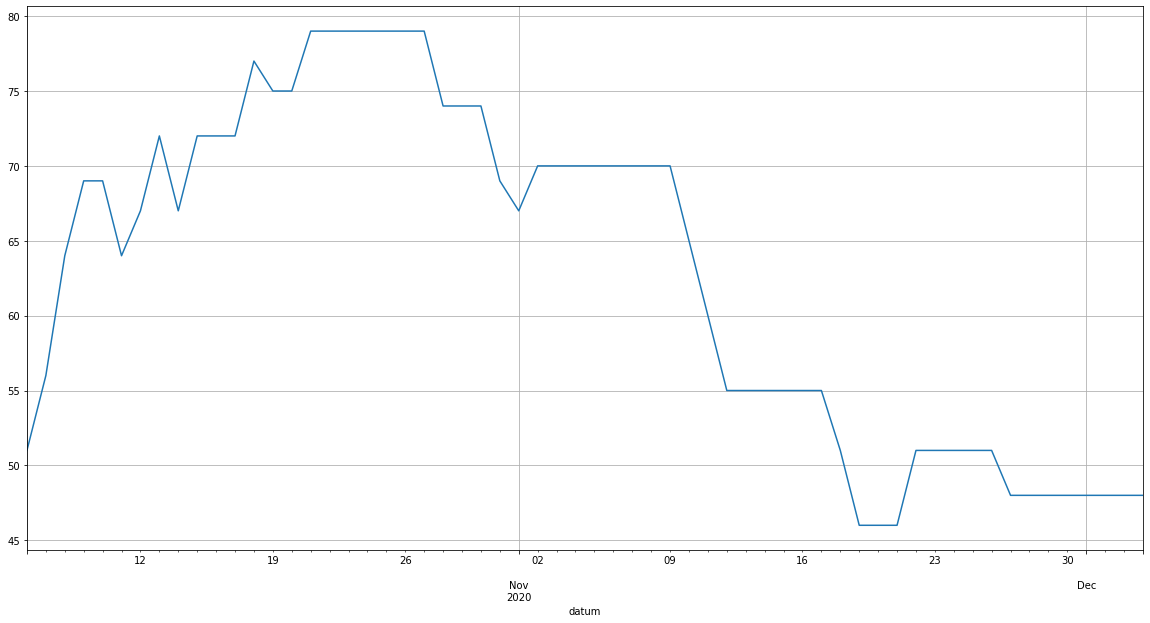

In [15]:
daily_data.dropna()['score'].iloc[-60:].plot(grid=True, figsize=(20,10))

In [16]:
daily_data.dropna()[['14day_count_score', 'senior_14day_count_score', 'r_score', '7day_test_positivity_score', 'score']].iloc[-14:]

,14day_count_score,senior_14day_count_score,r_score,7day_test_positivity_score,score
datum,,,,,
2020-11-21,16,10,0,20,46
2020-11-22,16,10,5,20,51
2020-11-23,16,10,5,20,51
2020-11-24,16,10,5,20,51
2020-11-25,16,10,5,20,51
2020-11-26,16,10,5,20,51
2020-11-27,16,7,5,20,48
2020-11-28,16,7,5,20,48
2020-11-29,16,7,5,20,48


In [18]:
daily_data.iloc[-14:]

,day_count,senior_day_count,test_count,14day_count_per_100k,senior_14day_count_per_100k,test_positivity,7day_test_positivity,r,14day_count_score,senior_14day_count_score,r_score,7day_test_positivity_score,score
datum,,,,,,,,,,,,,
2020-11-23,4339.0,996.0,23621.0,703.439584,146.497729,18.369248,21.907803,0.852369,16,10,5,20,51
2020-11-24,5818.0,1159.0,24629.0,673.680189,141.385169,23.622559,21.863304,0.932545,16,10,5,20,51
2020-11-25,4889.0,973.0,22635.0,636.490291,132.449873,21.599293,21.759819,0.958834,16,10,5,20,51
2020-11-26,4003.0,929.0,20491.0,600.870612,125.234341,19.535406,21.113182,0.913728,16,10,5,20,51
2020-11-27,4394.0,863.0,23326.0,573.541318,117.897304,18.837349,20.625391,0.882290,16,7,5,20,48
2020-11-28,2617.0,485.0,12305.0,558.942016,113.999795,21.267777,20.558480,0.892730,16,7,5,20,48
2020-11-29,1047.0,249.0,6450.0,551.118959,113.158607,16.232558,19.923456,0.834729,16,7,5,20,48
2020-11-30,3519.0,804.0,22265.0,534.183021,109.298484,15.805075,19.557145,0.824380,16,7,5,20,48
2020-12-01,5096.0,897.0,23136.0,542.464059,110.261178,22.026279,19.329105,0.867640,16,7,5,20,48
